# Week 5: GANs

Build a GAN that generates 7,000 to 10,000 Monet-style images.

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
# Set the directories for the Monet and photo images
monet_dir = 'C:/Users/gjaqu/Desktop/monet_jpg'
photo_dir = 'C:/Users/gjaqu/Desktop/photo_jpg'


# Use ImageDataGenerator to load the images from the directories
data_generator = ImageDataGenerator(rescale=1./255)

monet_dataset = data_generator.flow_from_directory(
    monet_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

photo_dataset = data_generator.flow_from_directory(
    photo_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)




Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [2]:
!pip install torchvision


In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    """
    Class to load a custom dataset
    """
    def __init__(self, img_path, img_size=(256, 256), normalize=True):
        self.img_path = img_path
        self.img_size = img_size
        
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(self.img_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.img_size),
                transforms.ToTensor()
            ])
        
        self.img_idx = os.listdir(self.img_path)
                
    def __len__(self):
        #Length of dataset --> number of images
        return len(self.img_idx)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_path, self.img_idx[idx])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        
        return img


In [4]:
from torch.utils.data import DataLoader

GCS_PATH_MONET = 'C:/Users/gjaqu/Desktop/monet_jpg'
GCS_PATH_PHOTO = 'C:/Users/gjaqu/Desktop/photo_jpg'

# Create datasets
dataset_monet = ImageDataset(GCS_PATH_MONET, img_size=(256, 256), normalize=True)
dataset_photo = ImageDataset(GCS_PATH_PHOTO, img_size=(256, 256), normalize=True)

# Create data loaders
loader_monet = DataLoader(dataset_monet, batch_size=32, shuffle=True)
loader_photo = DataLoader(dataset_photo, batch_size=32, shuffle=True)

# Iterate over the data loaders to get batches of images
for i, (batch_monet, batch_photo) in enumerate(zip(loader_monet, loader_photo)):
    # Do something with the batches of images
    print(f"Batch {i}: Monet shape={batch_monet.shape}, photo shape={batch_photo.shape}")


Batch 0: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 1: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 2: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 3: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 4: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 5: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 6: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 7: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 8: Monet shape=torch.Size([32, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])
Batch 9: Monet shape=torch.Size([12, 3, 256, 256]), photo shape=torch.Size([32, 3, 256, 256])


Implementation of the MiFID score in Python using PyTorch and TensorFlow:

In [5]:
import torch
import tensorflow as tf
import numpy as np
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from tensorflow.keras.applications.inception_v3 import InceptionV3

def calculate_activation_statistics(images, model):
    # Resize images to 299x299 for Inception v3 model
    images = adaptive_avg_pool2d(images, output_size=(299, 299))
    
    # Convert PyTorch tensor to numpy array and transpose to channels-first format
    images_np = images.detach().cpu().numpy().transpose(0, 2, 3, 1)
    
    # Preprocess images for Inception v3 model
    images_np = (images_np + 1) / 2.0 * 255.0
    images_np = tf.keras.applications.inception_v3.preprocess_input(images_np)
    
    # Get Inception v3 model activations for images
    activations = model.predict(images_np)
    
    # Calculate mean and covariance of activations
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    # Calculate squared difference between means
    diff = mu1 - mu2
    diff_squared = np.dot(diff, diff)
    
    # Calculate matrix square root of covariance product
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * 1e-6
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # Calculate squared Frobenius norm between covariances
    fid = diff_squared + np.trace(sigma1 + sigma2 - 2*covmean)
    
    return fid

def calculate_mifid_score(real_images, generated_images, model):
    # Calculate activation statistics for real and generated images
    mu1, sigma1 = calculate_activation_statistics(real_images, model)
    mu2, sigma2 = calculate_activation_statistics(generated_images, model)
    
    # Calculate FID score
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    
    # Calculate memorization index
    M = np.linalg.norm(sigma1 - sigma2, ord='fro') / np.linalg.norm(sigma1, ord='fro')
    
    # Calculate MiFID score
    mifid = fid * (1 + M)
    
    return mifid


In [8]:
conda install pytorch torchvision torchaudio -c pytorch


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\gjaqu\anaconda3

  added / updated specs:
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libuv-1.44.2               |       h2bbff1b_0         288 KB
    pytorch-1.13.1             |      py3.9_cpu_0       135.3 MB  pytorch
    pytorch-mutex-1.0          |              cpu           3 KB  pytorch
    torchaudio-0.13.1          |         py39_cpu         4.5 MB  pytorch
    torchvision-0.14.1         |         py39_cpu         6.3 MB  pytorch
    ------------------------------------------------------------
                                           Total:       146.4 MB

The following NEW packages will be INSTALLED:

  libuv              pkgs/main/win-64::libuv-1.44.2-h2bbff1b_0 


In [9]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


1.13.1+cpu
0.14.1+cpu


In [13]:
import torch
import tensorflow as tf
import numpy as np
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from tensorflow.keras.applications.inception_v3 import InceptionV3
import torchvision.transforms as transforms

# Download Inception v3 model from TensorFlow Keras Applications module
model_tf = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Convert TensorFlow model to PyTorch module using torchvision.models module
import torchvision.models as models
model = models.inception_v3(pretrained=False)
model.fc = torch.nn.Identity()
model.eval()

# Define batch size
batch_size = 32

# Create PyTorch tensors for real and generated images
real_images = torch.randn(batch_size, 3, 256, 256)
generated_images = torch.randn(batch_size, 3, 256, 256)

# Calculate MiFID score between real and generated images
mifid_score = calculate_mifid_score(real_images, generated_images, model_tf)
print("MiFID score:", mifid_score)


1/1 [==============================] - 2s 2s/step
MiFID score: (29.109951010953257-8.47185980667195e-07j)


## Build GAN

In [14]:
!pip install kaggle torch torchvision matplotlib numpy pandas


  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77717 sha256=a4f3fe01dca7abb0830236a79b90187c477420e3bc2d07d67d1e8813fe6e18fe
  Stored in directory: c:\users\gjaqu\appdata\local\pip\cache\wheels\9c\45\15\6d6d116cd2539fb8f450d64b0aee4a480e5366bb11b42ac763
Successfully built kaggle


In [18]:
import torch.nn as nn
import torch.optim as optim


TFRecord and Visualization

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    return gan_ds

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()

In [ ]:
display_samples(load_dataset(monet_dir).batch(1), 4, 6)

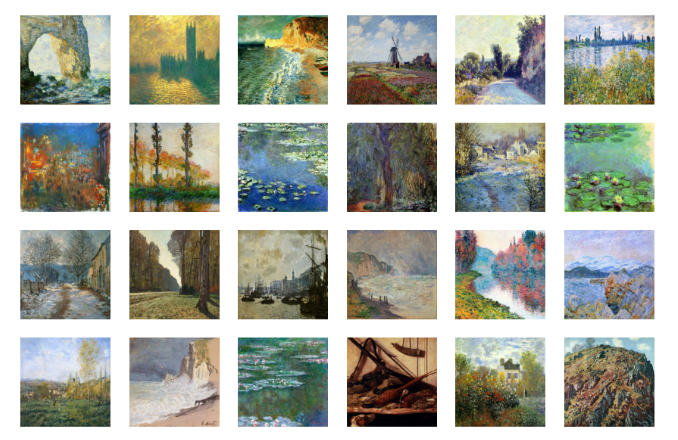

### Create Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, apply_instancenorm=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2, bias=False)
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if apply_instancenorm else None
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        x = self.activation(x)
        return x


Define two models- a generator and a discriminator.

In [22]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_channels=3):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.num_channels = num_channels

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        x = self.main(z)
        return x

class Discriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(Discriminator, self).__init__()

        self.num_channels = num_channels

        self.main = nn.Sequential(
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x.view(-1, 1)
        
# Instantiate generator and discriminator models
latent_dim = 100
num_channels = 3

generator = Generator(latent_dim=latent_dim, num_channels=num_channels)
discriminator = Discriminator(num_channels=num_channels)


In [ ]:
to_monet = generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

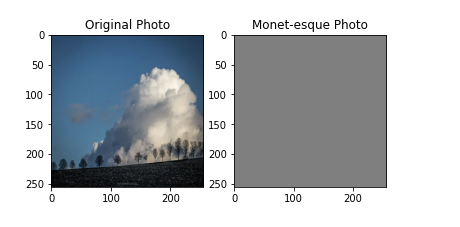

In [30]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        lambda_identity=0.5
    ):
        super(CycleGan, self).__init__()
        
        self.monet_generator = monet_generator
        self.photo_generator = photo_generator
        self.monet_discriminator = monet_discriminator
        self.photo_discriminator = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
        # Define inputs to the generators
        self.monet_input = Input(shape=(256, 256, 3), name="monet_input")
        self.photo_input = Input(shape=(256, 256, 3), name="photo_input")
        
        # Generate fake images
        self.monet_fake = self.monet_generator(self.photo_input)
        self.photo_fake = self.photo_generator(self.monet_input)
        
        # Cycle back to original images
        self.monet_cycle = self.monet_generator(self.photo_fake)
        self.photo_cycle = self.photo_generator(self.monet_fake)
        
        # Identity mapping
        self.monet_identity = self.monet_generator(self.monet_input)
        self.photo_identity = self.photo_generator(self.photo_input)


In [ ]:
def generator_loss(fake_output):
    return tf.reduce_mean(tf.square(fake_output - 1))


Training CycleGAN

In [ ]:
# Create an instance of the CycleGAN model
cycle_gan = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

# Define loss functions
adv_loss_fn = tf.keras.losses.MeanSquaredError()
cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

# Define optimizers
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Compile the CycleGAN model
cycle_gan.compile(
    gen_optimizer=gen_optimizer,
    disc_optimizer=disc_optimizer,
    adv_loss_fn=adv_loss_fn,
    cycle_loss_fn=cycle_loss_fn,
    identity_loss_fn=identity_loss_fn,
    lambda_cycle=10,
    lambda_identity=0.5,
)

# Train the CycleGAN model
cycle_gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50,
    steps_per_epoch=max(len(monet_files), len(photo_files)) // batch_size,
    callbacks=[tensorboard_callback],
)


Display Results of images

In [ ]:
_, ax = plt.subplots(6, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(6)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

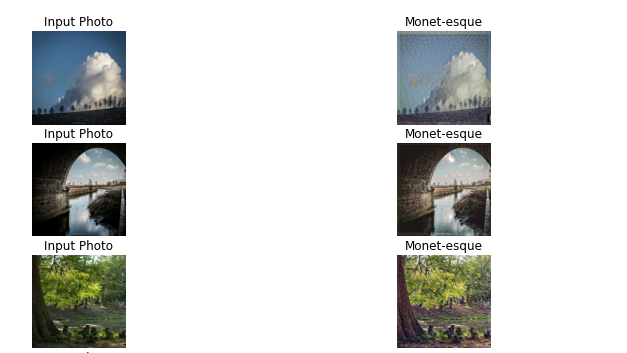